<a href="https://colab.research.google.com/github/cdurakci/nnet_ts_forecast_demos/blob/main/auto_neuralforecast_deneme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gerekli Olan Python Paketlerini Colab Ortamına Yükle
!pip install neuralforecast statsforecast datasetsforecast #hyperopt
#https://nixtlaverse.nixtla.io/neuralforecast/examples/getting_started_complete.html#4-train-multiple-models-for-many-series

In [2]:
import pandas as pd #CSV Veri Okutmak ve Veri manipülasyonu için R'daki DataFrame'in karşılığı
import numpy as np #

from neuralforecast import NeuralForecast # Ana Paketimiz
from neuralforecast.auto import AutoNHITS, AutoLSTM #, AutoRNN, AutoNBEATS, AutoDeepAR #Modellerin Otomatik Versiyonları
from neuralforecast.losses.pytorch import MQLoss, MAE #MQLoss Probabilistic Tahmin yapmak için, 80-90 Confidence Aralığında tahmin yapması için

from ray import tune # Hyperparameter Optimization yani Tuning yapan Library
from ray.tune.search.hyperopt import HyperOptSearch # Tuning Search Algoritması

path = 'KRDMD_data.csv'#'usdtry.csv' #Bu dosayayı yandaki dosya yükleme alanına sürükleyip bırakıyoruz
data = pd.read_csv(path, parse_dates=['Date'])
data.head() # verimiz klasick OHLC ve Volume Adjusted formatında

,Date,Id,Open,High,Low,Close,Volume,Adjusted
0,2017-01-02,0,1.15,1.15,1.14,1.15,8952995,1.15
1,2017-01-03,0,1.15,1.16,1.13,1.14,42792000,1.14
2,2017-01-04,0,1.14,1.14,1.11,1.12,31016884,1.12
3,2017-01-05,0,1.12,1.14,1.11,1.13,58083932,1.13
4,2017-01-06,0,1.13,1.14,1.13,1.14,7313235,1.14


In [3]:
data = data[['Date','Id','Close']] #Verideki bu Üç Kolonu seçiyoruz

In [4]:
# Kullandığımız NeuralForecast paketinin kendi kriteri, veriyi bu kolon isimleri ile istiyor tarih ds, target y, bir de unique_id olacak
#o yüzden yeniden isimlendiriyoruz
data = data.rename(columns={'Date': 'ds', 'Close': 'y', 'Id': 'unique_id'})

In [5]:
data.head() # Veriyi Kontrol Edelim

,ds,unique_id,y
0,2017-01-02,0,1.15
1,2017-01-03,0,1.14
2,2017-01-04,0,1.12
3,2017-01-05,0,1.13
4,2017-01-06,0,1.14


In [6]:
train = data.loc[data['ds'] <= '2022-12-31'] # 2023 öncesi veriyi Training Data olarak seçiyoruz
valid = data.loc[(data['ds'] > '2023-01-01') & (data['ds'] < '2024-02-06')] #2023 Sonrasını Holdout set, Out-of-Sample için tutuyoruz

h = valid['ds'].nunique() # Ne kadar adet veriyi valiation için ayırdık onu saydırıyoruz
h # sonra bunu parametre olarak kullanıp bu sayı kadar ilerisi için tahmin yaptırıcaz

270

In [7]:
train.head()

,ds,unique_id,y
0,2017-01-02,0,1.15
1,2017-01-03,0,1.14
2,2017-01-04,0,1.12
3,2017-01-05,0,1.13
4,2017-01-06,0,1.14


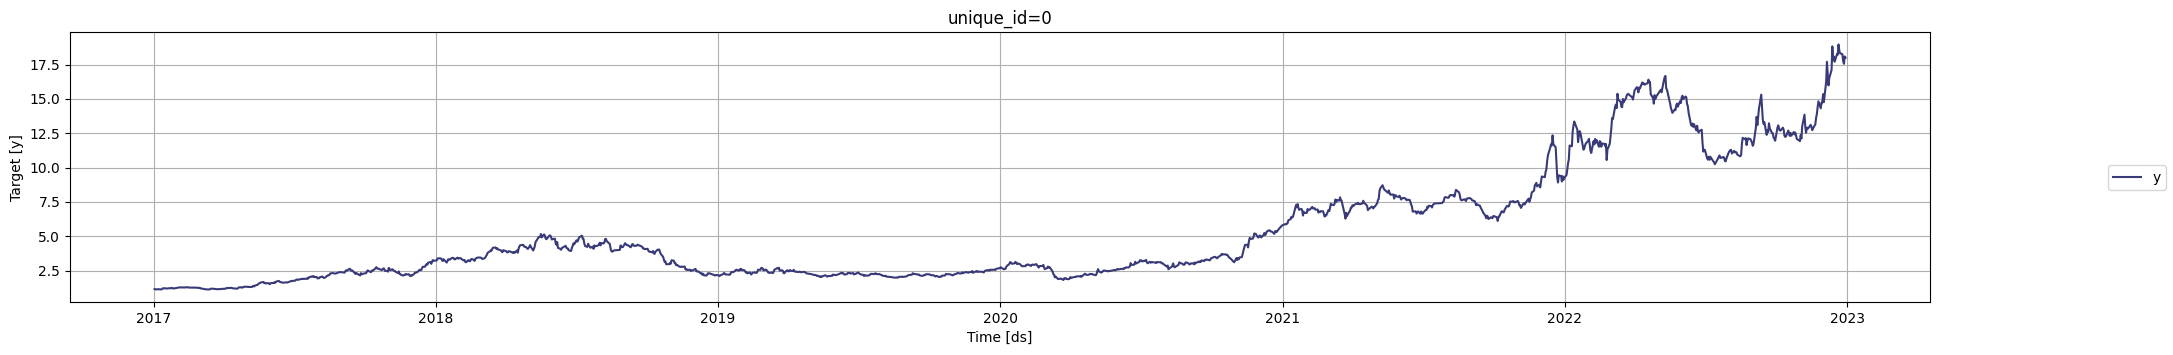

In [8]:
from statsforecast import StatsForecast #Grafik için plot fonksiyonun olduğu paketi import edelim

StatsForecast.plot(train, engine='matplotlib') #Çizdirelim

In [9]:
nhits_config = {
       "max_steps": 100,                                                         # Number of SGD steps
       "input_size": tune.choice([h, h*2]),                                 # Size of input window
       "learning_rate": tune.loguniform(1e-5, 1e-1),                             # Initial Learning rate
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1], [2, 1, 1]]), # Interpolation expressivity ratios
       "val_check_steps": 50,                                                    # Compute validation every 50 steps
       "random_seed": tune.randint(1, 10),                                       # Random seed
    }

In [10]:
AutoNHITS.default_config

{'input_size_multiplier': [1, 2, 3, 4, 5],
 'h': None,
 'n_pool_kernel_size': <ray.tune.search.sample.Categorical at 0x7f9962472140>,
 'n_freq_downsample': <ray.tune.search.sample.Categorical at 0x7f9962472200>,
 'learning_rate': <ray.tune.search.sample.Float at 0x7f9962472260>,
 'scaler_type': <ray.tune.search.sample.Categorical at 0x7f9962472320>,
 'max_steps': <ray.tune.search.sample.Float at 0x7f99624722c0>,
 'batch_size': <ray.tune.search.sample.Categorical at 0x7f99624724a0>,
 'windows_batch_size': <ray.tune.search.sample.Categorical at 0x7f9962472530>,
 'loss': None,
 'random_seed': <ray.tune.search.sample.Integer at 0x7f99624725c0>}

In [24]:
horizon = h

model = AutoNHITS(h = horizon, # Horizon Sayısı ileri tarihli kaç günlük tahmin isteniyor
                  loss = MQLoss(), # Probabilistic Tahmin Yapmak için, normal yapmak için MAE() MAPE() vs.
                  #config=None,
                  config = nhits_config,
                  search_alg = HyperOptSearch(), #bunları yukarda import etmiştik şimdi kullanıyorz
                  backend = 'ray',
                  num_samples = 20) #deneme yapma sayısı en az 20 ve üzeri tavsiye ediliyor

In [12]:
# Parametreler
# https://nixtlaverse.nixtla.io/neuralforecast/models.html

In [ ]:
nf = NeuralForecast(models=[model], freq='D') # NeuralForecast Objesini oluştur ve istediğimiz modellerin listesini veriyoruz
nf.fit(df=train, val_size=h) #Modeli fit() methoduyla veri ile train et, cross validation için ayrılması gereken veri miktarını belirle

In [26]:
nf.models[0].config # Kendimiz config belirlemediğimizde (config=None), kendi yaptığı config'in parametrelerinin ne buldugunu gör

{'max_steps': 100,
 'input_size': <ray.tune.search.sample.Categorical at 0x7f97b7610820>,
 'learning_rate': <ray.tune.search.sample.Float at 0x7f98090432b0>,
 'n_pool_kernel_size': <ray.tune.search.sample.Categorical at 0x7f9809043790>,
 'n_freq_downsample': <ray.tune.search.sample.Categorical at 0x7f9809043b20>,
 'val_check_steps': 50,
 'random_seed': <ray.tune.search.sample.Integer at 0x7f98090434c0>,
 'h': 270,
 'loss': MQLoss(),
 'valid_loss': MQLoss()}

In [27]:
results = nf.models[0].results.get_dataframe() # Farklı Paramerelerle Denediği modellerin ve sonuçlarının listesini al
results.head() # ilk 5 sıradakini göster
#results

,loss,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,...,config/input_size,config/learning_rate,config/n_pool_kernel_size,config/n_freq_downsample,config/val_check_steps,config/random_seed,config/h,config/loss,config/valid_loss,logdir
0,0.506175,1707671991,None,False,2,5f3829c6,2024-02-11_17-19-51,1.406168,7.303969,19291,...,270,0.000837,"(2, 2, 2)","(1, 1, 1)",50,4,270,MQLoss(),MQLoss(),5f3829c6
1,1.308830,1707671994,None,False,2,3ff08aae,2024-02-11_17-19-54,1.374949,3.185834,19291,...,540,0.000735,"(16, 8, 1)","(24, 12, 1)",50,2,270,MQLoss(),MQLoss(),3ff08aae
2,0.531617,1707671997,None,False,2,e398df1f,2024-02-11_17-19-57,1.407395,2.962177,19291,...,270,0.000900,"(2, 2, 2)","(1, 1, 1)",50,2,270,MQLoss(),MQLoss(),e398df1f
3,0.986955,1707672001,None,False,2,8e646aa4,2024-02-11_17-20-01,1.506875,3.046532,19291,...,270,0.000023,"(2, 2, 2)","(2, 1, 1)",50,3,270,MQLoss(),MQLoss(),8e646aa4
4,1.699920,1707672004,None,False,2,1adaa7da,2024-02-11_17-20-04,1.414825,3.177372,19291,...,270,0.000011,"(2, 2, 2)","(1, 1, 1)",50,2,270,MQLoss(),MQLoss(),1adaa7da


In [28]:
Y_hat_df = nf.predict() # Tahmini yaptır

Predicting: |          | 0/? [00:00<?, ?it/s]

In [29]:
Y_hat_df.columns = Y_hat_df.columns.str.replace('-median', '') #Median Değer bizim Point Estimate Tahminimiz
Y_hat_df

,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90
unique_id,,,,,,
0,2022-12-31,17.821012,17.120302,17.229198,18.095909,18.784599
0,2023-01-01,18.322119,17.510088,16.922485,19.000267,19.163710
0,2023-01-02,18.443464,17.595718,17.458662,18.134087,19.765734
0,2023-01-03,18.156988,17.139437,16.693518,18.905424,19.878904
0,2023-01-04,17.992514,17.018959,17.599915,19.441917,19.568089
...,...,...,...,...,...,...
0,2023-09-22,31.899240,21.044588,26.664036,39.317600,41.714775
0,2023-09-23,31.947941,26.463551,28.918285,39.444263,43.024582
0,2023-09-24,32.548397,25.692122,27.830374,39.870537,43.255241


In [30]:
Y_hat_df = Y_hat_df.reset_index().set_index('ds') #Tarihi dataframein indexi olarak set ediyoruz

Y_hat_df

,unique_id,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90
ds,,,,,,
2022-12-31,0,17.821012,17.120302,17.229198,18.095909,18.784599
2023-01-01,0,18.322119,17.510088,16.922485,19.000267,19.163710
2023-01-02,0,18.443464,17.595718,17.458662,18.134087,19.765734
2023-01-03,0,18.156988,17.139437,16.693518,18.905424,19.878904
2023-01-04,0,17.992514,17.018959,17.599915,19.441917,19.568089
...,...,...,...,...,...,...
2023-09-22,0,31.899240,21.044588,26.664036,39.317600,41.714775
2023-09-23,0,31.947941,26.463551,28.918285,39.444263,43.024582
2023-09-24,0,32.548397,25.692122,27.830374,39.870537,43.255241


In [19]:
#StatsForecast.plot(train, Y_hat_df[["AutoNHITS"]], engine='matplotlib', max_insample_length=h*2)

In [31]:
Y_hat_df_merged = Y_hat_df.merge(valid[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='left').dropna(axis=0).set_index('ds')
# tahminlerin bulunduğu dataframe ile validation (hold-out) verimizi birleştiriyoruz, ikisini de graifkte çizdirip üst üste görmek için

Y_hat_df_merged

,unique_id,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,y
ds,,,,,,,
2023-01-02,0,18.443464,17.595718,17.458662,18.134087,19.765734,18.52
2023-01-03,0,18.156988,17.139437,16.693518,18.905424,19.878904,18.81
2023-01-04,0,17.992514,17.018959,17.599915,19.441917,19.568089,19.79
2023-01-05,0,18.055164,17.169003,17.334608,19.051476,19.962870,18.00
2023-01-06,0,17.860380,16.316505,16.457506,19.391342,20.106262,19.26
...,...,...,...,...,...,...,...
2023-09-20,0,32.362690,26.557650,28.392269,39.704124,41.976418,25.60
2023-09-21,0,32.001019,25.282925,28.297367,38.732090,41.692333,26.46
2023-09-22,0,31.899240,21.044588,26.664036,39.317600,41.714775,27.52


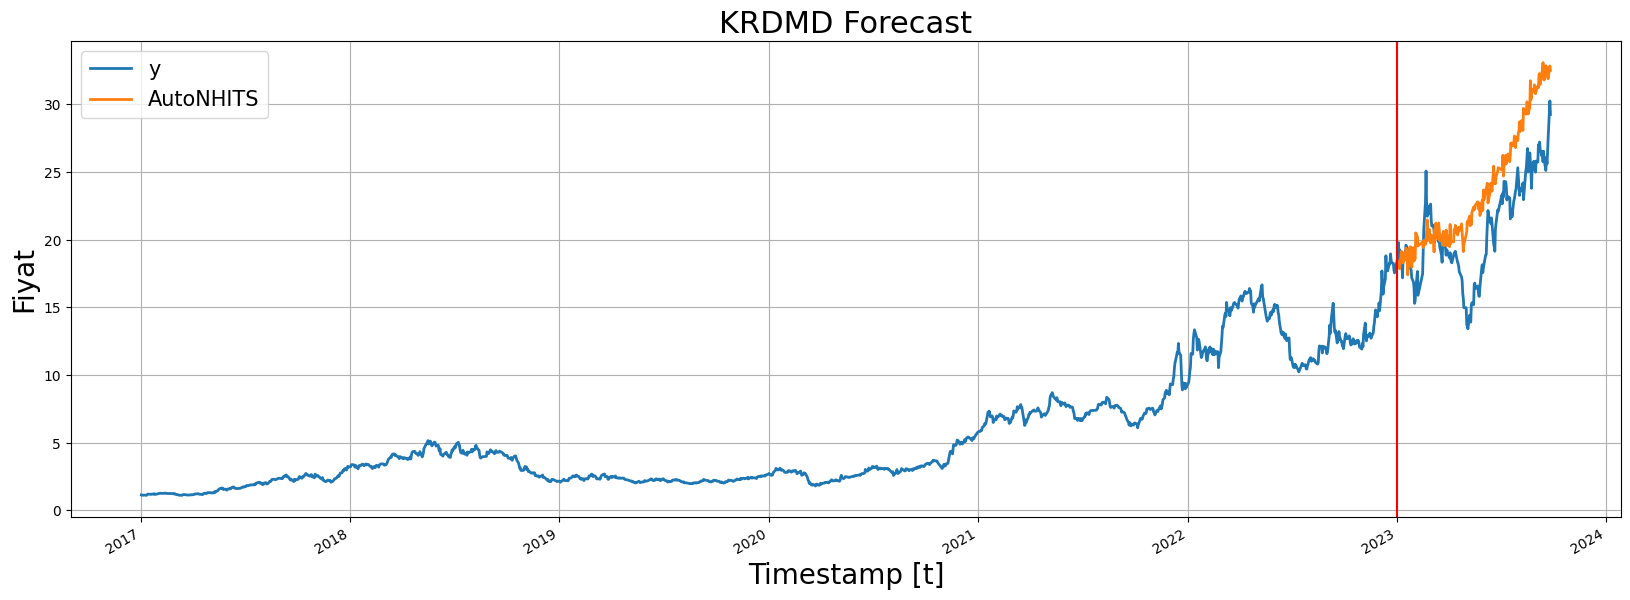

In [32]:
import matplotlib.pyplot as plt

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plot_df = pd.concat([train.set_index('ds'), Y_hat_df_merged]) # Concatenate the train and forecast dataframes
plot_df[['y', 'AutoNHITS']].plot(ax=ax, linewidth=2)

ax.set_title('KRDMD Forecast', fontsize=22)
ax.set_ylabel('Fiyat', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
plt.axvline('2023-01-01', color='red')

ax.legend(prop={'size': 15})
ax.grid()

#Probabilistic Forecast Plot - CI %80 - %90

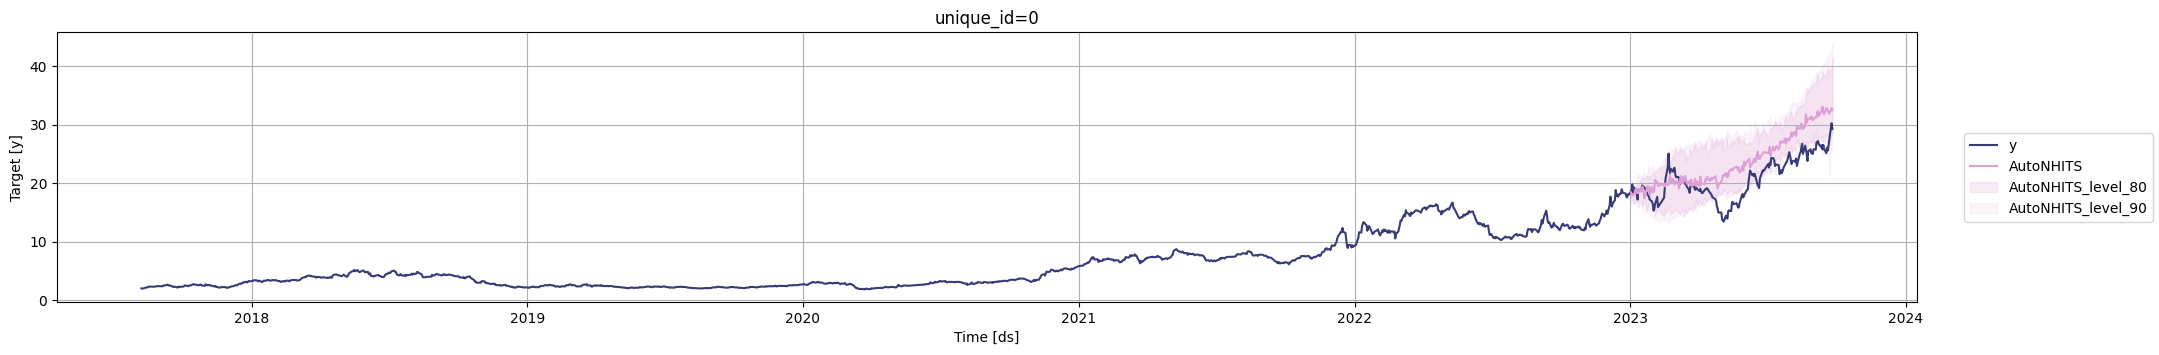

In [33]:
# Plot to unique_ids and some selected models

#StatsForecast.plot(train, Y_hat_df_merged.reset_index(), models=["AutoLSTM"], unique_ids=["0"], level=[80, 90], engine='matplotlib')
StatsForecast.plot(train, Y_hat_df_merged.reset_index(), engine='matplotlib', max_insample_length=h * 5, level=[80, 90])
